# Imports

In [2]:
# pip install langdetect googletrans==4.0.0rc1
# pip install transformers sentencepiece torch
# pip install tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score
from tqdm import tqdm
import joblib
import pickle
import re
from transformers import MarianMTModel, MarianTokenizer
import langid

import warnings
warnings.filterwarnings("ignore")

# Coleta e exploração inicial

Vamos agora ler os arquivos disponibilizados e começarmos a explorar os dados para entender sua estrutura

In [4]:
path_applicants = 'applicants.json'
path_prospects = 'prospects.json'
path_vagas = 'vagas.json'

In [5]:
with open(path_applicants, 'r', encoding='utf-8') as f:
    applicants_data = json.load(f)

with open(path_prospects, 'r', encoding='utf-8') as f:
    prospects_data = json.load(f)

with open(path_vagas, 'r', encoding='utf-8') as f:
    vagas_data = json.load(f)

In [6]:
print("Applicants - quantidade de candidatos:", len(applicants_data))
print("Prospects - quantidade de vagas:", len(prospects_data))
print("Vagas - quantidade de vagas:", len(vagas_data))


Applicants - quantidade de candidatos: 42482
Prospects - quantidade de vagas: 14222
Vagas - quantidade de vagas: 14081


In [7]:
print("\n--- Exemplo de candidato em applicants ---")
for i, (k, v) in enumerate(applicants_data.items()):
    print(f"ID {k}: {list(v.keys())}")
    if i == 2: break


--- Exemplo de candidato em applicants ---
ID 31000: ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en']
ID 31001: ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en']
ID 31002: ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en']


In [8]:
print("\n--- Exemplo de vaga em prospects ---")
for i, (k, v) in enumerate(prospects_data.items()):
    print(f"Vaga {k}: {v['titulo']}, {len(v['prospects'])} candidatos")
    if v['prospects']:
        print("  1º prospect:", v['prospects'][0])
    if i == 2: break


--- Exemplo de vaga em prospects ---
Vaga 4530: CONSULTOR CONTROL M, 2 candidatos
  1º prospect: {'nome': 'José Vieira', 'codigo': '25632', 'situacao_candidado': 'Encaminhado ao Requisitante', 'data_candidatura': '25-03-2021', 'ultima_atualizacao': '25-03-2021', 'comentario': 'Encaminhado para  - PJ R$ 72,00/hora', 'recrutador': 'Ana Lívia Moreira'}
Vaga 4531: 2021-2607395-PeopleSoft Application Engine-Domain Consultant, 2 candidatos
  1º prospect: {'nome': 'Sra. Yasmin Fernandes', 'codigo': '25364', 'situacao_candidado': 'Contratado pela Decision', 'data_candidatura': '17-03-2021', 'ultima_atualizacao': '12-04-2021', 'comentario': 'Data de Inicio: 12/04/2021', 'recrutador': 'Juliana Cassiano'}
Vaga 4532: , 0 candidatos


In [9]:
print("\n--- Exemplo de vaga em vagas ---")
for i, (k, v) in enumerate(vagas_data.items()):
    print(f"Vaga {k}: {v['informacoes_basicas'].get('titulo_vaga')}")
    print("  Perfil:", v['perfil_vaga'].get('principais_atividades', '')[:200], "...")
    if i == 2: break


--- Exemplo de vaga em vagas ---
Vaga 5185: Operation Lead -
  Perfil: Operations Lead

Roles & Responsibilities:
• The Operations Manager is accountable for delivering the run services towards a client or a specific set of clients.
• The Operations Manager has a firm wo ...
Vaga 5184: Consultor PP/QM Sênior
  Perfil: Consultor PP/QM Sr.

• Consultor PP/QM Sênior com experiencia em projetos de Rollout e implementação SAP ECC
• Inglês mandatório
• Remoto (Em alguns momentos / fases do projeto deverá estar presente n ...
Vaga 5183: ANALISTA PL/JR C/ SQL
  Perfil: Descrição – Atividades:

o Monitoramento das interfaces KDP
o Monitoramento sistema B2B durante o dia
o Monitoramento do Whatsapp durante o dia
o Monitoramento da subida de pedidos (KDP, WAE e B2B)
o  ...


In [10]:
print("\n--- Checando correspondência entre prospects e applicants ---")
matches = 0
checked = 0
for vaga_id, vaga in prospects_data.items():
    for p in vaga['prospects']:
        if p['codigo'] in applicants_data:
            matches += 1
        checked += 1
    if checked > 100: break
print(f"De {checked} prospects analisados, {matches} estão presentes no applicants.json.")


--- Checando correspondência entre prospects e applicants ---
De 101 prospects analisados, 94 estão presentes no applicants.json.


In [11]:
from collections import Counter

situacoes = []
for vaga in prospects_data.values():
    for p in vaga['prospects']:
        situacoes.append(p.get('situacao_candidado'))
print("\nDistribuição das situações dos candidatos (top 10):")
print(Counter(situacoes).most_common(10))


Distribuição das situações dos candidatos (top 10):
[('Prospect', 20021), ('Encaminhado ao Requisitante', 16122), ('Inscrito', 3980), ('Não Aprovado pelo Cliente', 3492), ('Contratado pela Decision', 2758), ('Desistiu', 2349), ('Não Aprovado pelo RH', 1765), ('Não Aprovado pelo Requisitante', 765), ('Entrevista Técnica', 579), ('Sem interesse nesta vaga', 576)]


# Definindo o target

Entendendo um pouco melhor nossa base de dados, vamos agora delimitar a forma com podemos identificar o candidato selecionado para a vaga

In [12]:
labels_sucesso = {'Contratado pela Decision', 'Contratado como Hunting', 'Aprovado'}

rows = []
for vaga_id, vaga in prospects_data.items():
    for p in vaga['prospects']:
        row = {
            'vaga_id': vaga_id,
            'candidato_id': p['codigo'],
            'nome_candidato': p['nome'],
            'situacao_candidado': p.get('situacao_candidado', None),
            'comentario': p.get('comentario', None),
            'recrutador': p.get('recrutador', None),
            'data_candidatura': p.get('data_candidatura', None),
            'ultima_atualizacao': p.get('ultima_atualizacao', None)
        }

        row['target'] = int(p.get('situacao_candidado', '') in labels_sucesso)
        rows.append(row)

df = pd.DataFrame(rows)

In [13]:
print("Shape do dataframe de pares vaga-candidato:", df.shape)
print("\nProporção de classes (target=1 é sucesso):")
print(df['target'].value_counts(normalize=True))
print("\n5 primeiras linhas:")
print(df.head())

Shape do dataframe de pares vaga-candidato: (53759, 9)

Proporção de classes (target=1 é sucesso):
target
0    0.940605
1    0.059395
Name: proportion, dtype: float64

5 primeiras linhas:
  vaga_id candidato_id            nome_candidato           situacao_candidado  \
0    4530        25632               José Vieira  Encaminhado ao Requisitante   
1    4530        25529  Srta. Isabela Cavalcante  Encaminhado ao Requisitante   
2    4531        25364     Sra. Yasmin Fernandes     Contratado pela Decision   
3    4531        25360            Alexia Barbosa  Encaminhado ao Requisitante   
4    4533        26338            Arthur Almeida     Contratado pela Decision   

                                          comentario         recrutador  \
0               Encaminhado para  - PJ R$ 72,00/hora  Ana Lívia Moreira   
1  encaminhado para  - R$ 6.000,00 – CLT Full , n...  Ana Lívia Moreira   
2                         Data de Inicio: 12/04/2021   Juliana Cassiano   
3                        

Considerando que temos apenas 6% das entradas com o target=1 para trabalharmos, precisaremos balancear isto de alguma forma posteriormente.

In [14]:
print("\nCandidatos por vaga (top 5):")
print(df['vaga_id'].value_counts().head())

print("\nVagas por candidato (top 5):")
print(df['candidato_id'].value_counts().head())

print("\nExemplo de registros positivos (target=1):")
print(df[df['target'] == 1].head())



Candidatos por vaga (top 5):
vaga_id
10898    25
9898     25
7645     25
11554    25
7644     25
Name: count, dtype: int64

Vagas por candidato (top 5):
candidato_id
833      73
1677     70
12450    54
27660    53
16747    45
Name: count, dtype: int64

Exemplo de registros positivos (target=1):
   vaga_id candidato_id         nome_candidato        situacao_candidado  \
2     4531        25364  Sra. Yasmin Fernandes  Contratado pela Decision   
4     4533        26338         Arthur Almeida  Contratado pela Decision   
16    4535        26338         Arthur Almeida                  Aprovado   
22    4535        22977            Lunna Alves  Contratado pela Decision   
38    4544        19972     Sr. Miguel Sampaio  Contratado pela Decision   

                        comentario         recrutador data_candidatura  \
2       Data de Inicio: 12/04/2021   Juliana Cassiano       17-03-2021   
4                                       Stella Vieira       29-04-2021   
16  Aprovado para inicio

O máximo de candidatos por vagas que identificamos é de 25.

Curioso que na base de dados temos candidatos se aplicando para múltiplas vagas, alguns com mais de 70 tentativas.

# Criação do dataframe estruturado

Sabendo que temos informações valiosas dos applicants e das vagas, vamos agora adicionar estas features e avaliá-las.

Primeiro criaremos funções para facilitar a replicação desta solução se necessário

In [15]:
def extract_applicant_features(applicant):
    f = {}
    # Infos básicas
    infos_basicas = applicant.get('infos_basicas', {})
    f['sexo'] = infos_basicas.get('sexo')
    f['idade'] = infos_basicas.get('idade')
    f['estado_civil'] = infos_basicas.get('estado_civil')
    
    # Informações profissionais
    info_prof = applicant.get('informacoes_profissionais', {})
    f['area_atuacao'] = info_prof.get('area_atuacao')
    f['nivel_profissional'] = info_prof.get('nivel_profissional')
    f['tempo_experiencia'] = info_prof.get('tempo_experiencia')
    f['ultimo_salario'] = info_prof.get('ultimo_salario')
    
    # Formação e idiomas
    formacao = applicant.get('formacao_e_idiomas', {})
    f['nivel_academico'] = formacao.get('nivel_academico')
    f['nivel_ingles'] = formacao.get('nivel_ingles')
    f['nivel_espanhol'] = formacao.get('nivel_espanhol')
    
    # Cargo atual
    f['cargo_atual'] = applicant.get('cargo_atual')
    
    # CVs
    f['cv_pt'] = applicant.get('cv_pt', '')
    f['cv_en'] = applicant.get('cv_en', '')
    return f

Visto que temos cv_pt e cv_en, porém identificamos vários cvs majotariamente em inglês, preciaríamos identificar o idioma corretamente

In [16]:
def extract_vaga_features(vaga):
    f = {}
    infos_basicas = vaga.get('informacoes_basicas', {})
    perfil = vaga.get('perfil_vaga', {})
    f['titulo_vaga'] = infos_basicas.get('titulo_vaga')
    f['cliente'] = infos_basicas.get('cliente')
    f['tipo_contratacao'] = infos_basicas.get('tipo_contratacao')
    f['nivel_profissional_vaga'] = perfil.get('nivel profissional')
    f['nivel_academico_vaga'] = perfil.get('nivel_academico')
    f['nivel_ingles_vaga'] = perfil.get('nivel_ingles')
    f['nivel_espanhol_vaga'] = perfil.get('nivel_espanhol')
    f['areas_atuacao_vaga'] = perfil.get('areas_atuacao')
    f['principais_atividades_vaga'] = perfil.get('principais_atividades', '')
    return f

In [17]:
def enrich_with_applicant(row):
    cand_id = row['candidato_id']
    applicant = applicants_data.get(cand_id)
    if applicant:
        feats = extract_applicant_features(applicant)
        for k, v in feats.items():
            row[f'cand_{k}'] = v
    else:
        for k in ['sexo', 'idade', 'estado_civil', 'area_atuacao', 'nivel_profissional', 
                  'tempo_experiencia', 'ultimo_salario', 'nivel_academico', 'nivel_ingles', 
                  'nivel_espanhol', 'cargo_atual', 'cv_pt', 'cv_en']:
            row[f'cand_{k}'] = np.nan
    return row

In [18]:
def enrich_with_vaga(row):
    vaga_id = row['vaga_id']
    vaga = vagas_data.get(vaga_id)
    if vaga:
        feats = extract_vaga_features(vaga)
        for k, v in feats.items():
            row[f'vaga_{k}'] = v
    else:
        for k in ['titulo_vaga', 'cliente', 'tipo_contratacao', 'nivel_profissional_vaga', 
                  'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 
                  'areas_atuacao_vaga', 'principais_atividades_vaga']:
            row[f'vaga_{k}'] = np.nan
    return row

Aplicar as funções que criamos para enriquecimento do df

In [ ]:
df = df.apply(enrich_with_applicant, axis=1)
df = df.apply(enrich_with_vaga, axis=1)
#3min+-

In [20]:
print("DataFrame enriquecido shape:", df.shape)
print("\nColunas disponíveis:", list(df.columns))
print("\nExemplo de linha:")
print(df.iloc[0][['candidato_id', 'cand_nivel_academico', 'cand_area_atuacao', 'cand_cv_pt', 
                  'vaga_titulo_vaga', 'vaga_nivel_profissional_vaga', 'vaga_principais_atividades_vaga']])


DataFrame enriquecido shape: (53759, 31)

Colunas disponíveis: ['vaga_id', 'candidato_id', 'nome_candidato', 'situacao_candidado', 'comentario', 'recrutador', 'data_candidatura', 'ultima_atualizacao', 'target', 'cand_sexo', 'cand_idade', 'cand_estado_civil', 'cand_area_atuacao', 'cand_nivel_profissional', 'cand_tempo_experiencia', 'cand_ultimo_salario', 'cand_nivel_academico', 'cand_nivel_ingles', 'cand_nivel_espanhol', 'cand_cargo_atual', 'cand_cv_pt', 'cand_cv_en', 'vaga_titulo_vaga', 'vaga_cliente', 'vaga_tipo_contratacao', 'vaga_nivel_profissional_vaga', 'vaga_nivel_academico_vaga', 'vaga_nivel_ingles_vaga', 'vaga_nivel_espanhol_vaga', 'vaga_areas_atuacao_vaga', 'vaga_principais_atividades_vaga']

Exemplo de linha:
candidato_id                                                                   25632
cand_nivel_academico                                                                
cand_area_atuacao                                                                   
cand_cv_pt      

# EDA

Vamos explorar um pouco os dados juntos

In [21]:
features_to_check = [
    'cand_nivel_academico', 'cand_area_atuacao', 'cand_nivel_ingles', 'cand_nivel_espanhol',
    'vaga_nivel_profissional_vaga', 'vaga_nivel_academico_vaga', 'vaga_nivel_ingles_vaga',
    'vaga_areas_atuacao_vaga', 'vaga_principais_atividades_vaga'
]
print("Percentual de preenchimento:")
for col in features_to_check:
    percent = df[col].notnull().mean() * 100
    print(f"{col}: {percent:.1f}%")

Percentual de preenchimento:
cand_nivel_academico: 83.9%
cand_area_atuacao: 83.9%
cand_nivel_ingles: 83.9%
cand_nivel_espanhol: 83.9%
vaga_nivel_profissional_vaga: 100.0%
vaga_nivel_academico_vaga: 100.0%
vaga_nivel_ingles_vaga: 100.0%
vaga_areas_atuacao_vaga: 100.0%
vaga_principais_atividades_vaga: 100.0%


Os campos relacionados às vagas estarem 100% preenchidos indica que são ótimos para considerarmos como features.

In [22]:
print("\nPrincipais valores (top 5) de cada coluna categórica:\n")
for col in ['cand_nivel_academico', 'cand_area_atuacao', 'cand_nivel_ingles', 'vaga_nivel_profissional_vaga']:
    print("\n")
    print(df[col].value_counts().head())


Principais valores (top 5) de cada coluna categórica:



cand_nivel_academico
                              33146
Ensino Superior Completo       5319
Pós Graduação Completo         3044
Ensino Superior Cursando       1256
Ensino Superior Incompleto      574
Name: count, dtype: int64


cand_area_atuacao
                                    33969
TI - Desenvolvimento/Programação     2251
TI - SAP                             1826
TI - Projetos                         742
Administrativa                        581
Name: count, dtype: int64


cand_nivel_ingles
                 33685
Intermediário     3949
Avançado          3166
Básico            2775
Fluente           1190
Name: count, dtype: int64


vaga_nivel_profissional_vaga
Sênior          20978
Analista        17887
Pleno            9852
Júnior           1984
Especialista     1124
Name: count, dtype: int64


Número considerável de entradas em branco, vamos tratar esses dados para evitar erros posteriormente

In [23]:
df['len_cv'] = df['cand_cv_pt'].fillna('').apply(len)
df['len_desc_vaga'] = df['vaga_principais_atividades_vaga'].fillna('').apply(len)
print("\nTamanho médio do CV (pt):", df['len_cv'].mean())
print("Tamanho médio da descrição da vaga:", df['len_desc_vaga'].mean())

print("\nAmostra de CV do candidato:")
print(df['cand_cv_pt'].dropna().iloc[0][:300])

print("\nAmostra de descrição da vaga:")
print(df['vaga_principais_atividades_vaga'].dropna().iloc[0][:300])



Tamanho médio do CV (pt): 4251.167358023773
Tamanho médio da descrição da vaga: 438.5958816198218

Amostra de CV do candidato:

dados pessoais
estado civil: casado
idade: 33 anos

objetivo
levar à empresa o meu conhecimento, tornando-me um membro a mais para o seu desenvolvimento.

formação acadêmica
universidade estácio de sá – rj
mba em ciência de dados e big data analytics - concluído

universidade estácio de sá – rj
sup

Amostra de descrição da vaga:
- Experiência comprovada em projetos de control-M


Função para definir como "Desconhecido" se tivermos valores faltantes

In [24]:
def clean_cat(col, default='Desconhecido'):
    return df[col].replace('', default).fillna(default)

In [25]:
for col in ['cand_nivel_academico', 'cand_area_atuacao', 'cand_nivel_ingles', 'cand_nivel_espanhol']:
    df[col] = clean_cat(col)

In [26]:
df['text_candidato'] = df['cand_cv_pt'].fillna('')
df['text_vaga'] = df['vaga_principais_atividades_vaga'].fillna('')

print("\nExemplo de texto candidato:\n", df['text_candidato'].iloc[0][:500])
print("\nExemplo de texto vaga:\n", df['text_vaga'].iloc[0][:300])


Exemplo de texto candidato:
 
dados pessoais
estado civil: casado
idade: 33 anos

objetivo
levar à empresa o meu conhecimento, tornando-me um membro a mais para o seu desenvolvimento.

formação acadêmica
universidade estácio de sá – rj
mba em ciência de dados e big data analytics - concluído

universidade estácio de sá – rj
superior em análise e desenvolvimento de sistemas - concluído

ete juscelino kubitschek– faetec
técnico em eletricidade - concluído

certificados;
• certificado itil foundadion v3


cursos de aperfeiçoam

Exemplo de texto vaga:
 - Experiência comprovada em projetos de control-M


# Embeddings

Como identificamos alguns cvs contendo muitos termos técnicos, uma mistura de português com inglês e também trechos com narrativas, vamos traduzir o conteúdo para português antes de fazermos o embedding com a finalidade de mantermos a eficiência do modelo posteriormente.

In [27]:
model_name = 'Helsinki-NLP/opus-mt-tc-big-en-pt'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def traduzir_en_para_pt(texto):
    if not texto or len(texto.strip()) == 0:
        return texto
    batch = tokenizer([texto], return_tensors="pt", truncation=True, padding=True)
    gen = model.generate(**batch)
    traduzido = tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
    return traduzido
    
def extrair_narrativa_cv(cv_texto):
    match = re.split(r'(experiência|experience|skills|habilidades|certificados)', cv_texto, flags=re.IGNORECASE)
    return match[0] if match else cv_texto[:1000] # 1000 caracteres

def extrair_skills_vaga(texto_vaga):
    # Extrai todas as palavras maiúsculas e siglas, além de algumas comuns em tech
    padrao = r'\b[A-Z]{2,}\b|\b(?:Java|Python|SQL|Azure|AWS|SAP|Excel|Linux|Agile|Node|React|C#|C\+\+|Oracle|BI|PowerBI|RPA|DevOps)\b'
    return set(re.findall(padrao, texto_vaga, flags=re.IGNORECASE))

def score_matching_skills(cv_texto, skills_vaga):
    skills_cv = set([x.lower() for x in re.findall(r'\b\w+\b', cv_texto)])
    skills_vaga = set([x.lower() for x in skills_vaga])
    if not skills_vaga:
        return 0
    return len(skills_cv & skills_vaga) / len(skills_vaga)

In [28]:
def detect_langid(text, default='pt'):
    if not isinstance(text, str) or not text.strip() or not re.search(r'[a-zA-Z]', text):
        return default
    lang, _ = langid.classify(text)
    return lang

----

# ROberto - olha aqui

Essa parte aqui na linha que tá comentada, vai tentar traduzir os CV em ingles... meu note demorou muito muito. Pra rodar, só troca e põe o # na próxima linha

In [29]:
textos_cv_processados = []
textos_vaga_processados = []
scores_skills = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    cv_texto = row['text_candidato']
    vaga_texto = row['text_vaga']
    lang_cv = detect_langid(cv_texto)
    #cv_traduzido = traduzir_en_para_pt(cv_texto) if lang_cv == 'en' else cv_texto
    cv_traduzido = cv_texto
    narrativa_cv = extrair_narrativa_cv(cv_traduzido)
    skills_vaga = extrair_skills_vaga(vaga_texto)
    score_skills = score_matching_skills(cv_traduzido, skills_vaga)
    textos_cv_processados.append(narrativa_cv)
    textos_vaga_processados.append(vaga_texto)
    scores_skills.append(score_skills)

100%|██████████| 53759/53759 [04:13<00:00, 212.13it/s]


In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

emb_candidato = model.encode(textos_cv_processados, show_progress_bar=True)
emb_vaga = model.encode(textos_vaga_processados, show_progress_bar=True)

similaridades = [cosine_similarity([emb_candidato[i]], [emb_vaga[i]])[0][0] for i in range(len(textos_cv_processados))]

df['similaridade_cv_vaga'] = similaridades
df['score_matching_skills'] = scores_skills

print("Preview de similaridades e matching de skills:")
print(df[['candidato_id', 'vaga_id', 'similaridade_cv_vaga', 'score_matching_skills', 'target']].head(10))

#df.to_csv('df_com_embeddings_e_skills.csv', index=False)
print("\nSubset salvo com embeddings, similaridade e score de matching de skills.")
#23min+-

Batches:   0%|          | 0/1680 [00:00<?, ?it/s]

Batches:   0%|          | 0/1680 [00:00<?, ?it/s]

Preview de similaridades e matching de skills:
  candidato_id vaga_id  similaridade_cv_vaga  score_matching_skills  target
0        25632    4530              0.390525               0.600000       0
1        25529    4530              0.301550               0.600000       0
2        25364    4531              0.595539               0.153846       1
3        25360    4531              0.429766               0.138462       0
4        26338    4533              0.398069               0.700000       1
5        24645    4533              0.514896               0.500000       0
6        26361    4534              0.257040               0.529412       0
7        26205    4534              0.339967               0.529412       0
8        26003    4534              0.393927               0.705882       0
9        25509    4534              0.494434               0.117647       0

Subset salvo com embeddings, similaridade e score de matching de skills.


Vamos testar se a similaridade entre os embeddings de CV e da vaga indicam uma relação com o target

Target=0 (não contratado): média = 0.31084913  | std = 0.17078568  | n = 50566
Target=1 (contratado):      média = 0.29237732  | std = 0.16752498  | n = 3193

Teste t para diferença de médias: t=-6.036, p-valor=0.0000


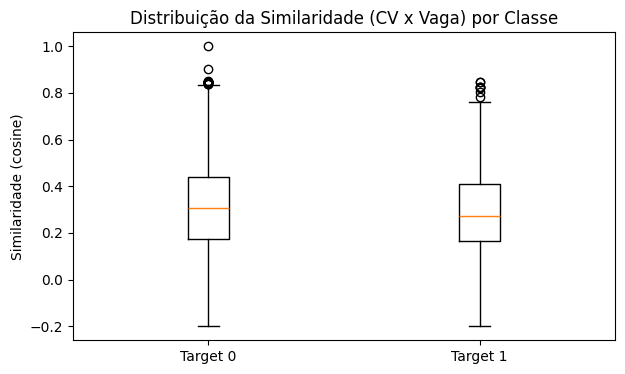

In [31]:
# Estatísticas básicas
grupo_0 = df[df['target'] == 0]['similaridade_cv_vaga']
grupo_1 = df[df['target'] == 1]['similaridade_cv_vaga']

print("Target=0 (não contratado): média =", grupo_0.mean(), " | std =", grupo_0.std(), " | n =", len(grupo_0))
print("Target=1 (contratado):      média =", grupo_1.mean(), " | std =", grupo_1.std(), " | n =", len(grupo_1))

# Teste t para diferença de médias
tstat, pval = ttest_ind(grupo_1, grupo_0, equal_var=False)
print(f"\nTeste t para diferença de médias: t={tstat:.3f}, p-valor={pval:.4f}")

# Gráfico boxplot
plt.figure(figsize=(7, 4))
plt.boxplot([grupo_0, grupo_1], tick_labels=['Target 0', 'Target 1'])
plt.title("Distribuição da Similaridade (CV x Vaga) por Classe")
plt.ylabel("Similaridade (cosine)")
plt.show()

Apesar do p-value mostrar diferença estatística (porque a amostra é grande), a diferença prática (média de 0.31 vs 0.30) é pequena e o boxplot mostra muita sobreposição das distribuições.

Similaridade entre CV e vaga não é um bom critério preditivo isolado de contratação e bem na verdade, para contratados tende a ser até um pouco menor

Isso pode refletir o contexto de TI e recrutamento, onde fatores não explícitos no texto (network, experiência específica, indicações, requisitos do cliente, etc) pesam mais do que “palavras em comum”.

# Pipeline

Seleção das features

Aqui tivemos que categorizar a similaridade do cv com a vaga. 

O principal problema que enfrentamos foi que a similaridade tomava conta da relevância na escolha do candidato, porém percebia-se que o candidato efetivamente escolhido não tem a influencia direta exclusiva da relação do CV com a vaga, mostrando que outros fatores 

In [32]:
df['similaridade_cv_vaga_bin'] = pd.cut(df['similaridade_cv_vaga'], bins=[0, 0.25, 0.5, 0.75, 1], labels=[0,1,2,3])

Seleção das features que temos interesse

In [33]:
features = [
    'cand_nivel_academico', 
    'cand_area_atuacao', 
    'cand_nivel_ingles', 
    'cand_nivel_espanhol',
    'cand_nivel_profissional',
    'vaga_nivel_academico_vaga', 
    'vaga_areas_atuacao_vaga', 
    'vaga_nivel_ingles_vaga',
    'vaga_nivel_espanhol_vaga',
    'vaga_nivel_profissional_vaga',
    'similaridade_cv_vaga_bin',
    'score_matching_skills'
]

X = df[features]
y = df['target']


Pré processamento das variáves categóricas

In [34]:
X_enc = pd.get_dummies(X, drop_first=True)

Split em treino e teste

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, stratify=y, random_state=42
)

Treino de RandomForesst

In [36]:
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1,
    
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

Avaliação


Relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     10113
           1       0.22      0.34      0.27       639

    accuracy                           0.89     10752
   macro avg       0.59      0.63      0.60     10752
weighted avg       0.91      0.89      0.90     10752


AUC ROC: 0.723045083514038

Matriz de confusão:
[[9325  788]
 [ 419  220]]


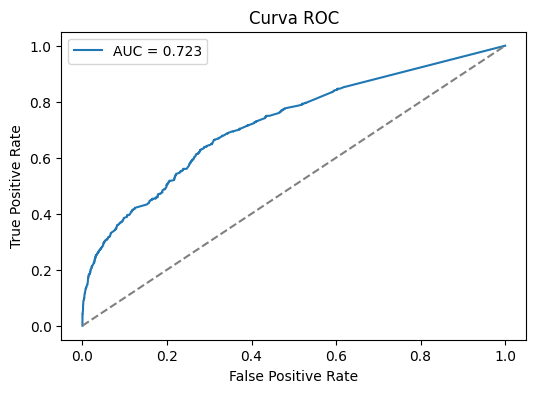

In [37]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred, digits=2))

print("\nAUC ROC:", roc_auc_score(y_test, y_proba))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1],[0,1],'--',color='grey')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Avaliar a importância de cada feature no score


Importância das features (top 10):
score_matching_skills                      0.356147
vaga_nivel_ingles_vaga_Nenhum              0.046757
vaga_areas_atuacao_vaga_TI - Projetos-     0.035193
similaridade_cv_vaga_bin_1                 0.031346
vaga_nivel_profissional_vaga_Sênior        0.026415
vaga_areas_atuacao_vaga_Administrativa-    0.026084
vaga_nivel_espanhol_vaga_Básico            0.024875
vaga_nivel_espanhol_vaga_Nenhum            0.021935
vaga_nivel_ingles_vaga_Básico              0.019235
similaridade_cv_vaga_bin_2                 0.019212
dtype: float64


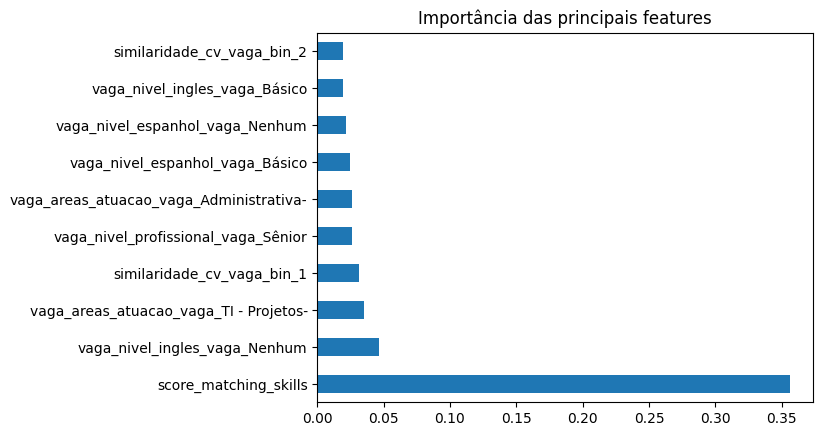

In [38]:
importances = pd.Series(clf.feature_importances_, index=X_enc.columns).sort_values(ascending=False)
print("\nImportância das features (top 10):")
print(importances.head(10))
importances.head(10).plot(kind='barh', title='Importância das principais features')
plt.show()

Avaliar um threshold melhor

Melhor threshold para maior F1: 0.64
Precision: 0.333, Recall: 0.250, F1: 0.286


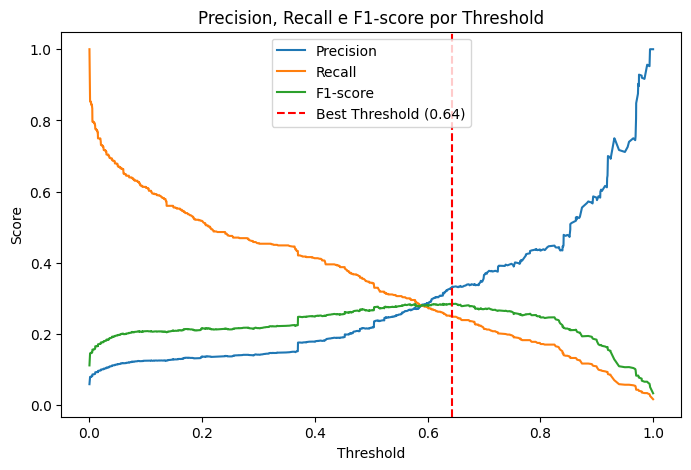


Relatório com threshold customizado:
              precision    recall  f1-score   support

           0      0.953     0.968     0.961     10113
           1      0.333     0.250     0.286       639

    accuracy                          0.926     10752
   macro avg      0.643     0.609     0.623     10752
weighted avg      0.917     0.926     0.921     10752

[[9793  320]
 [ 479  160]]


In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f'Melhor threshold para maior F1: {best_threshold:.2f}')
print(f'Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}, F1: {f1s[best_idx]:.3f}')

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1s[:-1], label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1-score por Threshold')
plt.legend()
plt.show()

y_pred_custom = (y_proba >= best_threshold).astype(int)
print("\nRelatório com threshold customizado:")
print(classification_report(y_test, y_pred_custom, digits=3))
print(confusion_matrix(y_test, y_pred_custom))

Ajustando para o threshold identificado como ideal

In [40]:
# usa o primeiro se quiser o original, se não o clf.predict_proba
#y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
threshold = 0.64

y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("Matriz do confuso:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      0.953     0.967     0.960     10113
           1      0.327     0.250     0.283       639

    accuracy                          0.925     10752
   macro avg      0.640     0.609     0.622     10752
weighted avg      0.916     0.925     0.920     10752

Matriz do confuso:
[[9783  330]
 [ 479  160]]


Utilizamos ajuste de threshold para maximizar o F1-score, obtendo um equilíbrio prático entre precision e recall para a predição de contratações. O threshold ótimo (0.64) permitiu identificar contratados com uma precisão boa, mesmo em um cenário de forte desbalanceamento, mostrando que o modelo pode ser ajustado conforme a estratégia do negócio — seja priorizando recall (acertar mais contratados) ou precision (evitar falsos positivos).

# Exportar o modelo

In [41]:
joblib.dump(clf, 'modelo_rf.pkl')

['modelo_rf.pkl']

In [42]:
X_train_enc = pd.get_dummies(X_train)
with open('features.pkl', 'wb') as f:
    pickle.dump(list(X_train_enc.columns), f)

In [43]:
threshold_otimo = 0.66
with open('threshold.txt', 'w') as f:
    f.write(str(threshold_otimo))

In [44]:
importances = clf.feature_importances_
with open('importances.pkl', 'wb') as f:
    pickle.dump(importances, f)